In [1]:
import torch
import matplotlib.pyplot as plt
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset, reserve_color
import json
from tenLoader import normalize, get_boundary_iou
import torch.nn as nn
import torch.optim as optim
from MyLoss import get_edges, deviation_loss, total_len_loss
import numpy as np
from tqdm import tqdm
import time
import math
import torchvision.transforms as transforms
from PIL import Image
from copy import deepcopy

In [2]:
train_rawset = DAVIS_Rawset(is_train=True)

In [3]:
val_rawset = DAVIS_Rawset(is_train=False)

In [4]:
len(train_rawset.data_set)

144

In [5]:
len(val_rawset.data_set)

61

In [80]:
hard_polygon = SoftPolygon(0.01, mode="hard_mask").cuda()

In [7]:
ras_loss = RasLoss().cuda()

In [27]:
class BoundarySampler(nn.Module):
    def __init__(
        self,
        init_boundary=None,
    ):
        super(BoundarySampler, self).__init__()
        if init_boundary is not None:
            self.boundary_points = nn.Parameter(init_boundary)
        else:
            self.boundary_points = nn.Parameter(
                torch.Tensor(
                    [
                        [0.0, 0.0],
                        [0.0, 224.0],
                        [224.0, 224.0],
                        [224.0, 0.0],
                    ]
                )
            )

    def forward(self):
        boundary = self.boundary_points
        boundary = torch.clamp(boundary, 0, 224)
        boundary = boundary.unsqueeze(0)
        return boundary

    def add_mid_points(self):
        # add mid points to the boundary
        boundary = self.boundary_points
        boundary_shift = torch.roll(boundary, 1, 0)
        # print(f"boundary: {boundary}")
        # print(f"boundary_shift: {boundary_shift}")
        mid_points = (boundary + boundary_shift) / 2
        # print(f"mid_points: {mid_points}")
        boundary_num = boundary.shape[0]
        new_boundary = torch.zeros(boundary_num * 2, 2).to(boundary.device)
        new_boundary[::2] = mid_points
        new_boundary[1::2] = boundary
        self.boundary_points = nn.Parameter(new_boundary)

    def get_numpy(self) -> np.ndarray:
        boundary = self.forward().squeeze(0).cpu().detach().numpy()
        return boundary

    def get_mask(self, hard_polygon: nn.Module):
        boudary = self.forward()
        mask = hard_polygon(boudary, 224, 224)
        return mask.squeeze(0).cpu().detach().numpy()

    def get_extreme_4_points(self):
        boundary = self.forward().squeeze(0)
        x_min = torch.min(boundary[:, 0])
        x_max = torch.max(boundary[:, 0])
        y_min = torch.min(boundary[:, 1])
        y_max = torch.max(boundary[:, 1])
        return torch.Tensor(
            [
                [x_min, y_min],
                [x_min, y_max],
                [x_max, y_max],
                [x_max, y_min],
            ],
        ).to(boundary.device)

In [112]:
boundary_sampler = BoundarySampler().cuda()

In [81]:
boundary_sampler.boundary_points

Parameter containing:
tensor([[152.4505, 168.2274],
        [153.5400, 164.4108],
        [149.7195, 164.5119],
        [147.3098, 157.6217],
        [145.5924, 153.5387],
        [145.4557, 146.8758],
        [141.3144, 142.5910],
        [142.6911, 135.9137],
        [145.2427, 127.2219],
        [146.6915, 118.8797],
        [149.2507, 110.3618],
        [151.6404, 101.7300],
        [153.7988,  97.5200],
        [157.6738,  97.4725],
        [161.6884,  96.1851],
        [166.1517,  93.9421],
        [167.5010,  84.5095],
        [167.4939,  75.8904],
        [164.3709,  69.9589],
        [164.4991,  64.1867],
        [163.5354,  62.1943],
        [163.4628,  54.3293],
        [164.1971,  48.7714],
        [166.7315,  42.9068],
        [170.6382,  38.7506],
        [175.4830,  37.2849],
        [180.2541,  39.6551],
        [183.4193,  42.8401],
        [183.6221,  46.0834],
        [185.4314,  53.1662],
        [185.5608,  59.8403],
        [187.6562,  67.3953],
        [186.4942,

In [120]:
boundary_sampler.add_mid_points()

In [124]:
boundary_sampler.boundary_points.shape

torch.Size([16, 2])

In [23]:
def get_polygon_iou(
    polygon: torch.Tensor,
    mask: torch.Tensor,
    hard_polygon: nn.Module,
) -> float:
    if mask.sum() == 0:
        return 1
    polygon_batch = polygon.unsqueeze(0)
    mask_batch = mask.unsqueeze(0)
    ras_mask = hard_polygon(
        polygon_batch,
        mask_batch.shape[2],
        mask_batch.shape[1],
    )
    ras_mask = ras_mask.squeeze(0)
    ras_mask[ras_mask == -1] = 0
    interction = torch.sum(ras_mask * mask)
    union = torch.sum(ras_mask) + torch.sum(mask) - interction
    iou = interction / union
    return iou.item()


IoU: 0.8860


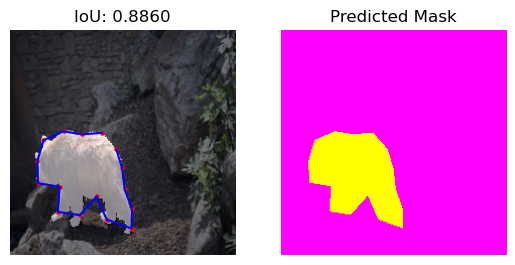

In [123]:
boundary = boundary_sampler().squeeze(0)
boundary.shape, boundary
video_idx = 0
frame_idx = 0
img, mask = train_rawset.data_set[video_idx][frame_idx]
iou = get_polygon_iou(
    boundary.to("cuda"),
    mask.to("cuda"),
    hard_polygon,
)
boundary = boundary_sampler.get_numpy()
print(f"IoU: {iou:.4f}")
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.plot(
    boundary[:, 0],
    boundary[:, 1],
    "b-",
    # lw=5,
)
plt.scatter(
    boundary[:, 0],
    boundary[:, 1],
    c="r",
    s=5,
)
plt.imshow(
    mask.cpu().numpy(),
    alpha=0.5,
    cmap="gray",
)
plt.title(f"IoU: {iou:.4f}")
plt.subplot(1, 2, 2)
plt.imshow(
    boundary_sampler.get_mask(hard_polygon),
    cmap="spring",
    vmin=0,
    vmax=1,
)
plt.axis("off")
plt.title("Predicted Mask")
plt.show()

In [17]:
img, mask = val_rawset.data_set[video_idx][frame_idx + 1]

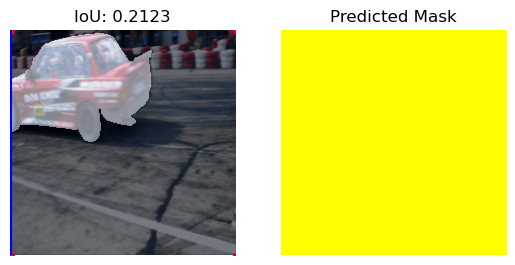

In [18]:
extreme_4_points = boundary_sampler.get_extreme_4_points()
new_boundary_sampler = BoundarySampler(extreme_4_points).cuda()
# plot the new boundary
boundary = new_boundary_sampler().squeeze(0)
boundary = boundary.cpu().detach().numpy()
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.plot(
    boundary[:, 0],
    boundary[:, 1],
    "b-",
    # lw=5,
)
plt.scatter(
    boundary[:, 0],
    boundary[:, 1],
    c="r",
    s=20,
)
plt.imshow(
    mask.cpu().numpy(),
    alpha=0.5,
    cmap="gray",
)
boundary = new_boundary_sampler().squeeze(0)
plt.title(f"IoU: {get_polygon_iou(boundary, mask.cuda(), hard_polygon):.4f}")
plt.subplot(1, 2, 2)
plt.imshow(
    new_boundary_sampler.get_mask(hard_polygon),
    cmap="spring",
    vmin=0,
    vmax=1,
)
plt.axis("off")
plt.title("Predicted Mask")
plt.show()


In [86]:
epoch_num = 100

In [122]:
loss_dict = {}
loss_dict["dif_loss"] = []
loss_dict["cos_loss"] = []
loss_dict["std_loss"] = []
loss_dict["len_loss"] = []
loss_dict["total_loss"] = []
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(boundary_sampler.parameters(), lr=1e-0)
dif_weight = 0.5
std_weight = 0.5
# len_weight = 0.1
mask_batch = mask.unsqueeze(0).cuda()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    boundary_points = boundary_sampler()
    dif_loss = ras_loss(boundary_points, mask_batch)
    std_loss = deviation_loss(boundary_points)
    len_loss = total_len_loss(boundary_points)
    if std_loss < 0.01:
        total_loss = dif_weight * dif_loss
    else:
        total_loss = dif_weight * dif_loss + std_weight * std_loss
    # if std_loss < 0.01:
    #     total_loss = dif_weight * dif_loss + len_weight * len_loss
    # else:
    #     total_loss = (
    #         dif_weight * dif_loss + std_weight * std_loss + len_weight * len_loss
    #     )
    loss_dict["dif_loss"].append(dif_loss.item())
    loss_dict["std_loss"].append(std_loss.item())
    loss_dict["len_loss"].append(len_loss.item())
    loss_dict["total_loss"].append(total_loss.item())
    # total_loss = boundary.mean()
    total_loss.backward()
    print(
        f"epoch: {epoch}, dif_loss: {dif_loss:.4f}, std_loss: {std_loss:.4f}, len_loss: {len_loss:.4f}, total_loss: {total_loss:.4f}",
    )
    optimizer.step()

epoch: 0, dif_loss: 0.0974, std_loss: 0.0045, len_loss: 0.0895, total_loss: 0.0487
epoch: 1, dif_loss: 0.0908, std_loss: 0.0079, len_loss: 0.0898, total_loss: 0.0454
epoch: 2, dif_loss: 0.0859, std_loss: 0.0108, len_loss: 0.0905, total_loss: 0.0484
epoch: 3, dif_loss: 0.0825, std_loss: 0.0087, len_loss: 0.0912, total_loss: 0.0413
epoch: 4, dif_loss: 0.0792, std_loss: 0.0080, len_loss: 0.0920, total_loss: 0.0396
epoch: 5, dif_loss: 0.0771, std_loss: 0.0084, len_loss: 0.0929, total_loss: 0.0385
epoch: 6, dif_loss: 0.0743, std_loss: 0.0095, len_loss: 0.0938, total_loss: 0.0371
epoch: 7, dif_loss: 0.0714, std_loss: 0.0116, len_loss: 0.0947, total_loss: 0.0415
epoch: 8, dif_loss: 0.0681, std_loss: 0.0119, len_loss: 0.0954, total_loss: 0.0400
epoch: 9, dif_loss: 0.0655, std_loss: 0.0114, len_loss: 0.0961, total_loss: 0.0385
epoch: 10, dif_loss: 0.0637, std_loss: 0.0108, len_loss: 0.0967, total_loss: 0.0373
epoch: 11, dif_loss: 0.0631, std_loss: 0.0104, len_loss: 0.0975, total_loss: 0.0367
ep

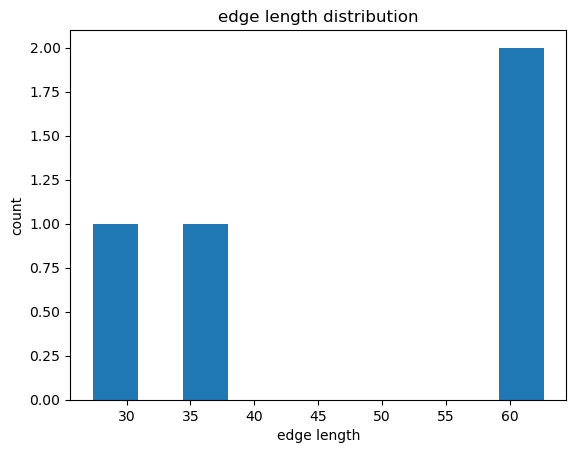

In [16]:
edges = get_edges(boundary_sampler())[0]
plt.hist(edges.cpu().detach().numpy(), bins=10)
plt.title("edge length distribution")
plt.xlabel("edge length")
plt.ylabel("count")
plt.show()

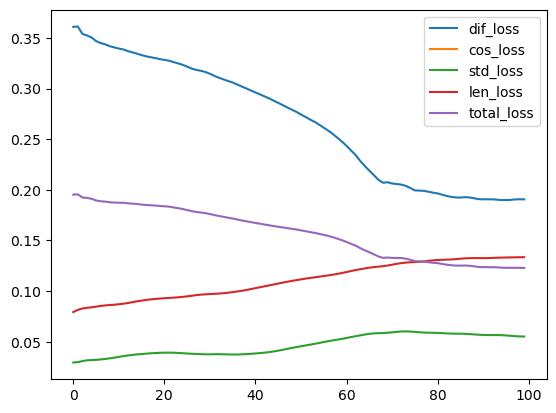

In [58]:
# plt the loss curve
plt.plot(loss_dict["dif_loss"], label="dif_loss")
plt.plot(loss_dict["cos_loss"], label="cos_loss")
plt.plot(loss_dict["std_loss"], label="std_loss")
plt.plot(loss_dict["len_loss"], label="len_loss")
plt.plot(loss_dict["total_loss"], label="total_loss")
plt.legend()

In [26]:
boundary_sampler.get_numpy().tolist()

[[74.4195785522461, 132.0005340576172],
 [76.60279083251953, 224.0],
 [157.63381958007812, 224.0],
 [155.05809020996094, 135.09295654296875]]

In [127]:
def show_result(img: torch.Tensor, mask: torch.Tensor, result: dict):
    boundary = result["boundary"]
    tensor_boundary = torch.tensor(boundary, dtype=torch.float32).unsqueeze(0).cuda()
    boundary = np.array(boundary)
    hard_polygon = SoftPolygon(0.01, mode="hard_mask").cuda()
    iou = result["iou"]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.imshow(mask.cpu().numpy(), alpha=0.5, cmap="gray")
    plt.axis("off")
    plt.title("ground truth")
    plt.subplot(1, 3, 2)
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.plot(
        boundary[:, 0],
        boundary[:, 1],
        "b-",
        # lw=5,
    )
    plt.scatter(
        boundary[:, 0],
        boundary[:, 1],
        c="r",
        s=10,
    )
    plt.title(f"IoU: {iou:.4f}")
    plt.subplot(1, 3, 3)
    pred_mask = hard_polygon(
        tensor_boundary,
        mask.shape[1],
        mask.shape[0],
    )
    pred_mask = pred_mask.squeeze(0).cpu().detach().numpy()
    plt.imshow(pred_mask, cmap="spring", vmin=0, vmax=1)
    plt.axis("off")
    plt.title("predicted mask")
    plt.show()

In [324]:
type(boundary_sampler.boundary_points.shape[0])

int

In [46]:
def sample_one_frame(
    mask: torch.Tensor,
    max_point_num: int,
    use_std_loss: bool,
    fir_epoch_multi: int,
    hard_polygon: nn.Module,
    epoch_num: int,
    ras_loss: nn.Module,
    boundary_sampler: BoundarySampler,
) -> dict:
    results = {}
    mask_batch = mask.unsqueeze(0).cuda()
    current_point_num = boundary_sampler.boundary_points.shape[0]
    if use_std_loss:
        dif_weight = 0.5
        std_weight = 0.5
    else:
        dif_weight = 1.0
        std_weight = 0.0
    while current_point_num <= max_point_num:
        optimizer = optim.Adam(boundary_sampler.parameters(), lr=1)
        if current_point_num == 4:
            tmp_epoch_num = epoch_num * fir_epoch_multi
        else:
            tmp_epoch_num = epoch_num
        for epoch in range(tmp_epoch_num):
            optimizer.zero_grad()
            boundary_points = boundary_sampler()
            dif_loss = ras_loss(boundary_points, mask_batch)
            std_loss = deviation_loss(boundary_points)
            if std_loss < 0.01:
                total_loss = dif_weight * dif_loss
            else:
                total_loss = dif_weight * dif_loss + std_weight * std_loss
            total_loss.backward()
            optimizer.step()
        iou = get_polygon_iou(
            boundary_sampler().squeeze(0),
            mask_batch.squeeze(0),
            hard_polygon,
        )
        current_result = {}
        current_result["boundary"] = boundary_sampler.get_numpy().tolist()
        current_result["iou"] = iou
        results[current_point_num] = current_result
        boundary_sampler.add_mid_points()
        current_point_num = boundary_sampler.boundary_points.shape[0]
    torch.cuda.empty_cache()
    return results


# video_idx = 40
# frame_idx = 17
# img, mask = train_rawset.data_set[video_idx][frame_idx]
# boundary_sampler = BoundarySampler().cuda()
# results = sample_one_frame(
#     mask=mask,
#     max_point_num=256,
#     use_std_loss=True,
#     fir_epoch_multi=25,
#     hard_polygon=hard_polygon,
#     epoch_num=100,
#     ras_loss=ras_loss,
#     boundary_sampler=boundary_sampler,
# )

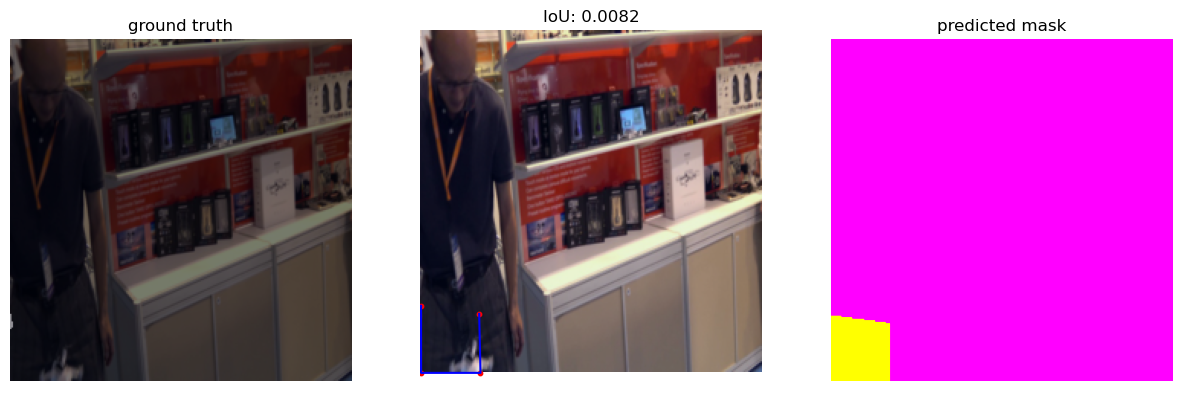

In [314]:
show_result(img, mask, results[4])

In [278]:
img, mask = train_rawset.data_set[40][17]
mask.sum()

tensor(14.)

In [250]:
video_idx = 40
frame_idx = 16
img, mask = train_rawset.data_set[video_idx][frame_idx]
new_boundary_sampler = BoundarySampler(boundary_sampler.get_extreme_4_points()).cuda()
results = sample_one_frame(
    mask=mask,
    max_point_num=256,
    use_std_loss=True,
    fir_epoch_multi=1,
    hard_polygon=hard_polygon,
    epoch_num=100,
    ras_loss=ras_loss,
    boundary_sampler=new_boundary_sampler,
)

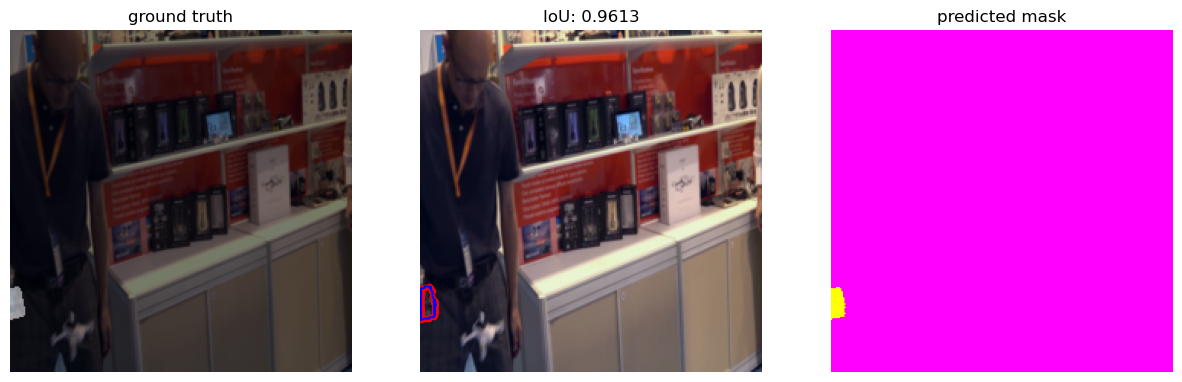

In [251]:
show_result(img, mask, results[256])

In [252]:
video_idx = 40
frame_idx = 17
img, mask = train_rawset.data_set[video_idx][frame_idx]
new_boundary_sampler = BoundarySampler(new_boundary_sampler.get_extreme_4_points()).cuda()
results = sample_one_frame(
    mask=mask,
    max_point_num=256,
    use_std_loss=True,
    fir_epoch_multi=1,
    hard_polygon=hard_polygon,
    epoch_num=100,
    ras_loss=ras_loss,
    boundary_sampler=new_boundary_sampler,
)

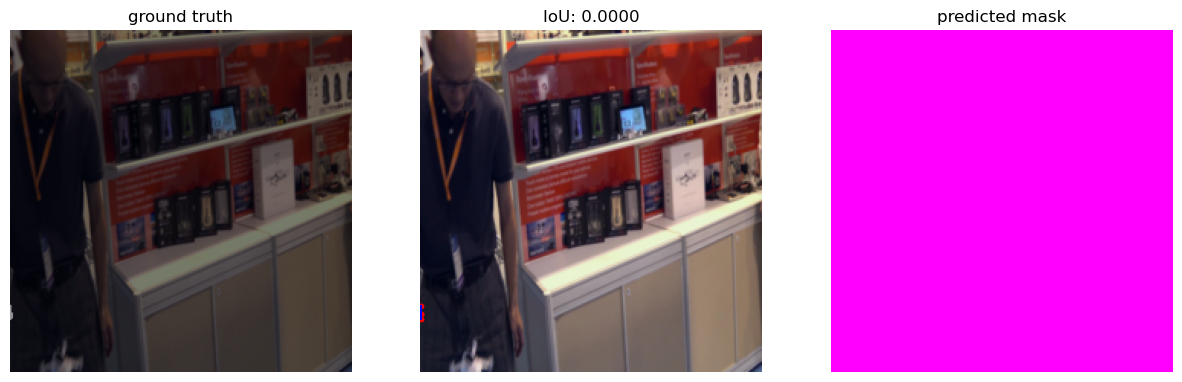

In [254]:
show_result(img, mask, results[4])

In [316]:
def sample_one_video(
    video_data: list[tuple],
    max_point_num: int,
    use_std_loss: bool,
    fir_epoch_multi: int,
    hard_polygon: nn.Module,
    epoch_num: int,
    ras_loss: nn.Module,
    min_threshold: int,
) -> list:
    results = []
    boundary_sampler = BoundarySampler().cuda()
    for frame_idx, (img, mask) in tqdm(enumerate(video_data)):
        if mask.sum() < min_threshold:
            tmp_fir_epoch_multi = fir_epoch_multi * 5
        else:
            tmp_fir_epoch_multi = fir_epoch_multi
        if frame_idx == 0:
            results.append(
                sample_one_frame(
                    mask=mask,
                    max_point_num=max_point_num,
                    use_std_loss=use_std_loss,
                    fir_epoch_multi=tmp_fir_epoch_multi,
                    hard_polygon=hard_polygon,
                    epoch_num=epoch_num,
                    ras_loss=ras_loss,
                    boundary_sampler=boundary_sampler,
                ),
            )
        else:
            refine_result = sample_one_frame(
                mask=mask,
                max_point_num=max_point_num,
                use_std_loss=use_std_loss,
                fir_epoch_multi=1,
                hard_polygon=hard_polygon,
                epoch_num=epoch_num,
                ras_loss=ras_loss,
                boundary_sampler=boundary_sampler,
            )
            new_boundary_sampler = BoundarySampler().cuda()
            new_result = sample_one_frame(
                mask=mask,
                max_point_num=max_point_num,
                use_std_loss=use_std_loss,
                fir_epoch_multi=tmp_fir_epoch_multi,
                hard_polygon=hard_polygon,
                epoch_num=epoch_num,
                ras_loss=ras_loss,
                boundary_sampler=new_boundary_sampler,
            )
            if refine_result[256]["iou"] > new_result[256]["iou"]:
                results.append(refine_result)
            else:
                results.append(new_result)
                boundary_sampler = new_boundary_sampler
        boundary_sampler = BoundarySampler(boundary_sampler.get_extreme_4_points()).cuda()
    return results


video_results = sample_one_video(
    video_data=train_rawset.data_set[40],
    max_point_num=256,
    use_std_loss=True,
    fir_epoch_multi=5,
    hard_polygon=hard_polygon,
    epoch_num=100,
    ras_loss=ras_loss,
    min_threshold=25,
)

91it [19:28, 12.84s/it]


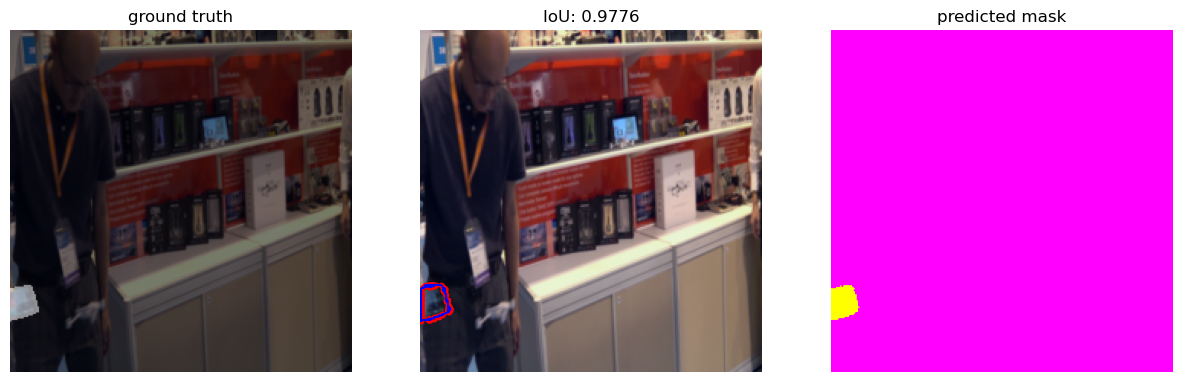

In [319]:
frame_idx = 15
show_result(train_rawset.data_set[40][frame_idx][0], train_rawset.data_set[40][frame_idx][1], video_results[frame_idx][256])

In [322]:
def get_video_iou(video_results: list) -> float:
    iou_list = []
    for result in video_results:
        iou_list.append(result[256]["iou"])
    return np.mean(iou_list)
get_video_iou(video_results)

0.950886838383727

In [55]:
def sample_save_dataset(
    video_dataset: list,
    start_idx: int,
    save_title: str,
    max_point_num: int,
    use_std_loss: bool,
    epoch_num=100,
):
    save_path = f"{save_title}_{start_idx}_{max_point_num}_{"std" if use_std_loss else ""}_{epoch_num}.json"
    results = []
    for video_data in video_dataset:
        result = sample_one_video(video_data, max_point_num, use_std_loss, epoch_num)
        results.append(result)
    with open(save_path, "w") as f:
        json.dump(results, f, )
sample_save_dataset(val_rawset.data_set[1:2], 1, "val", 256, True, 100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [05:35<00:00,  4.86s/it]


In [125]:
# load the saved results
def load_results(
    start_idx: int,
    save_title: str,
    max_point_num: int,
    use_std_loss: bool,
    epoch_num=100,
    fir_epoch_multi=None,
    min_threshold=None,
):
    save_path = f"./sample_results/{save_title}_{start_idx}_{max_point_num}_{"std" if use_std_loss else ""}_{epoch_num}.json"
    if fir_epoch_multi is not None:
        save_path = f"./sample_results/{save_title}_{start_idx}_{max_point_num}_{"std" if use_std_loss else ""}_{epoch_num}_{fir_epoch_multi}.json"
        if min_threshold is not None:
            save_path = f"./sample_results/{save_title}_{start_idx}_{max_point_num}_{"std" if use_std_loss else ""}_{epoch_num}_{fir_epoch_multi}_{min_threshold}.json"
    with open(save_path, "r") as f:
        results = json.load(f)

    def numericalize_dict(d: dict):
        result = {}
        for key, value in d.items():
            result[int(key)] = value
        return result

    # numericalize the results
    for video_result in results:
        for frame_idx, frame_result in enumerate(video_result):
            video_result[frame_idx] = numericalize_dict(frame_result)

    return results


results = load_results(1, "val", 256, True, 100)

In [20]:
len(results[0][0][128]["boundary"])

128

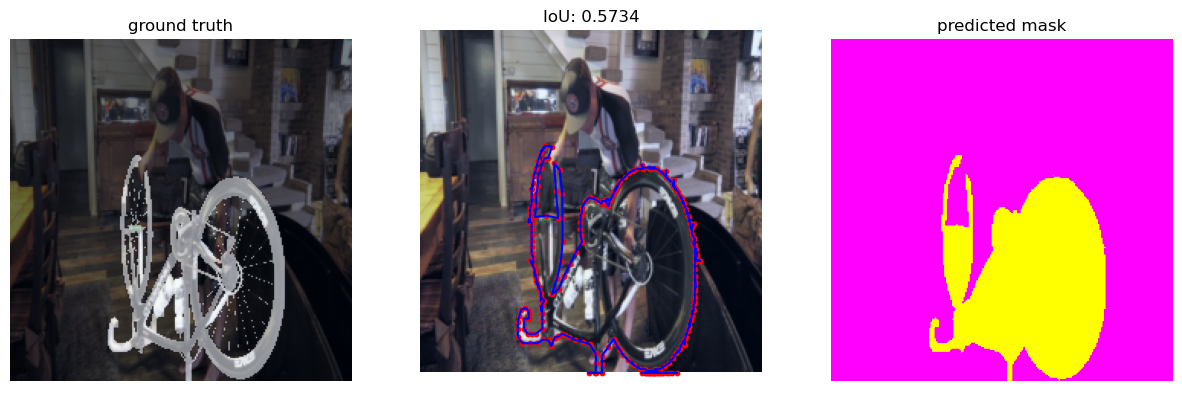

In [128]:
frame_idx = 20
show_result(val_rawset.data_set[1][frame_idx][0], val_rawset.data_set[1][frame_idx][1], results[0][frame_idx][256])

In [ ]:
# sample the validation dataset
sample_save_dataset(val_rawset.data_set, 0, "val", 256, True, 100)
# sample the first half of the training dataset
sample_save_dataset(
    train_rawset.data_set[: len(train_rawset.data_set) // 2], 0, "train", 256, True, 100
)
# sample the second half of the training dataset
sample_save_dataset(
    train_rawset.data_set[len(train_rawset.data_set) // 2 :],
    len(train_rawset.data_set) // 2,
    "train",
    256,
    True,
    100,
)

In [129]:
old_val_sample_set = load_results(
    0,
    "val",
    256,
    True,
    100,
)
old_train_sample_set_first_half = load_results(
    0,
    "train",
    256,
    True,
    100,
)
old_train_sample_set_second_half = load_results(
    len(train_rawset.data_set) // 2,
    "train",
    256,
    True,
    100,
)
old_train_sample_set = (
    old_train_sample_set_first_half + old_train_sample_set_second_half
)

In [130]:
val_sample_set = load_results(
    0,
    "val",
    256,
    True,
    100,
    5,
)

In [131]:
def recompute_iou(
    sample_set: list,
    raw_dataset: list,
    hard_polygon: nn.Module,
):
    for video_idx, video_result in enumerate(sample_set):
        for frame_idx, frame_result in enumerate(video_result):
            img, mask = raw_dataset[video_idx][frame_idx]
            for point_num, result in frame_result.items():
                boundary = torch.tensor(result["boundary"], dtype=torch.float32).cuda()
                iou = get_polygon_iou(boundary, mask.cuda(), hard_polygon)
                result["iou"] = iou


recompute_iou(val_sample_set, val_rawset.data_set, hard_polygon)
recompute_iou(old_val_sample_set, val_rawset.data_set, hard_polygon)
recompute_iou(old_train_sample_set, train_rawset.data_set, hard_polygon)

(-0.5, 223.5, 223.5, -0.5)

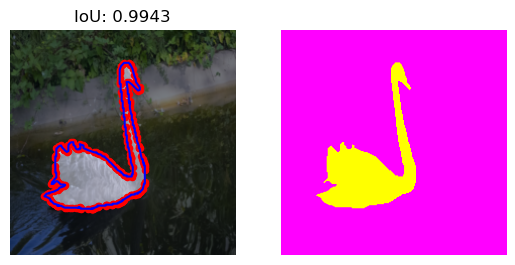

In [79]:
video_idx = 2
frame_idx = 1
point_num = 256
img, mask = val_rawset.data_set[video_idx][frame_idx]
boundary = torch.tensor(val_sample_set[video_idx][frame_idx][point_num]["boundary"], dtype=torch.float32).cuda()
iou = get_polygon_iou(boundary, mask.cuda(), hard_polygon)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.plot(
    boundary.squeeze(0).cpu().detach().numpy()[:, 0],
    boundary.squeeze(0).cpu().detach().numpy()[:, 1],
    "b-",
    # lw=5,
)
plt.scatter(
    boundary.squeeze(0).cpu().detach().numpy()[:, 0],
    boundary.squeeze(0).cpu().detach().numpy()[:, 1],
    c="r",
    s=20,
)
plt.imshow(
    mask.cpu().numpy(),
    alpha=0.5,
    cmap="gray",
)
plt.title(f"IoU: {iou:.4f}")
plt.subplot(1, 2, 2)
plt.imshow(
    hard_polygon(boundary.unsqueeze(0), 224, 224).squeeze(0).cpu().detach().numpy(),
    cmap="spring",
    vmin=0,
    vmax=1,
)
plt.axis("off")

In [59]:
mask.sum()

tensor(5055.)

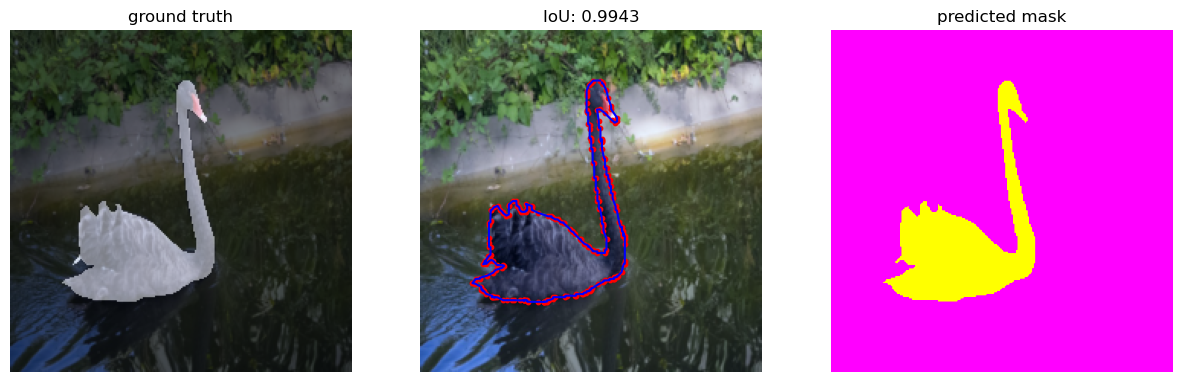

In [80]:
video_idx = 2
frame_idx = 1
show_result(
    val_rawset.data_set[video_idx][frame_idx][0],
    val_rawset.data_set[video_idx][frame_idx][1],
    val_sample_set[video_idx][frame_idx][256],
)

In [132]:
train_sample_set_fir_half = load_results(
    0,
    "train",
    256,
    True,
    100,
    5,
)
train_sample_set_sec_half = load_results(
    len(train_rawset.data_set) // 2,
    "train",
    256,
    True,
    100,
    5,
)

In [133]:
train_sample_set = train_sample_set_fir_half + train_sample_set_sec_half

In [134]:
recompute_iou(train_sample_set, train_rawset.data_set, hard_polygon)

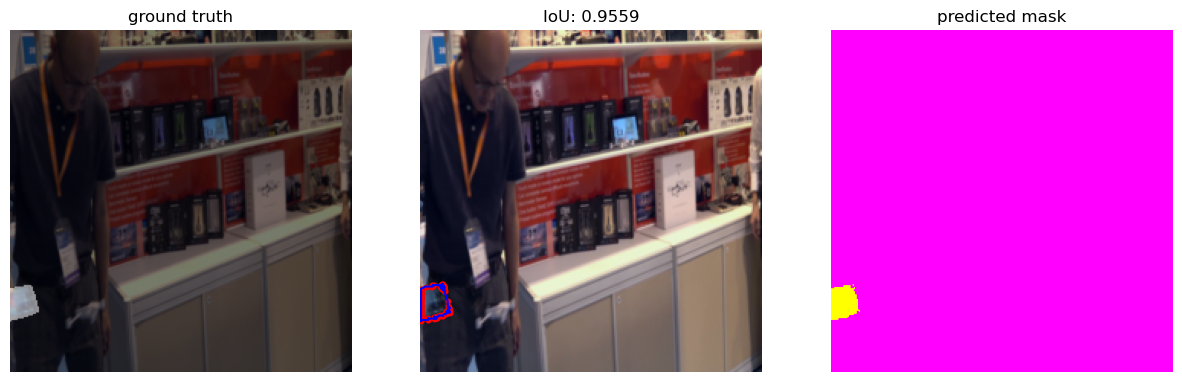

In [19]:
video_idx = 40
frame_idx = 15
point_num = 256
show_result(
    train_rawset.data_set[video_idx][frame_idx][0],
    train_rawset.data_set[video_idx][frame_idx][1],
    train_sample_set[video_idx][frame_idx][point_num],
)

In [136]:
new_val_sample_set = load_results(0, "val", 256, True, 100, 5, 25)

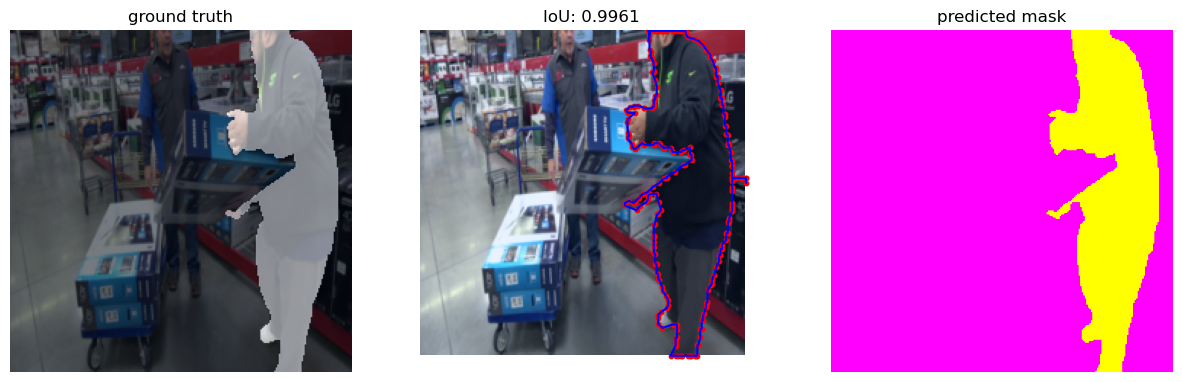

In [138]:
video_idx = 40
frame_idx = 25
point_num = 256
show_result(
    val_rawset.data_set[video_idx][frame_idx][0],
    val_rawset.data_set[video_idx][frame_idx][1],
    new_val_sample_set[video_idx][frame_idx][point_num],
)

In [137]:
new_train_sample_set_0_0 = load_results(0, "train", 256, True, 100, 5, 25)
new_train_sample_set_0_1 = load_results(len(train_rawset.data_set) // 4, "train", 256, True, 100, 5, 25)
new_train_sample_set_1 = load_results(len(train_rawset.data_set) // 2, "train", 256, True, 100, 5, 25)
new_train_sample_set = new_train_sample_set_0_0 + new_train_sample_set_0_1 + new_train_sample_set_1

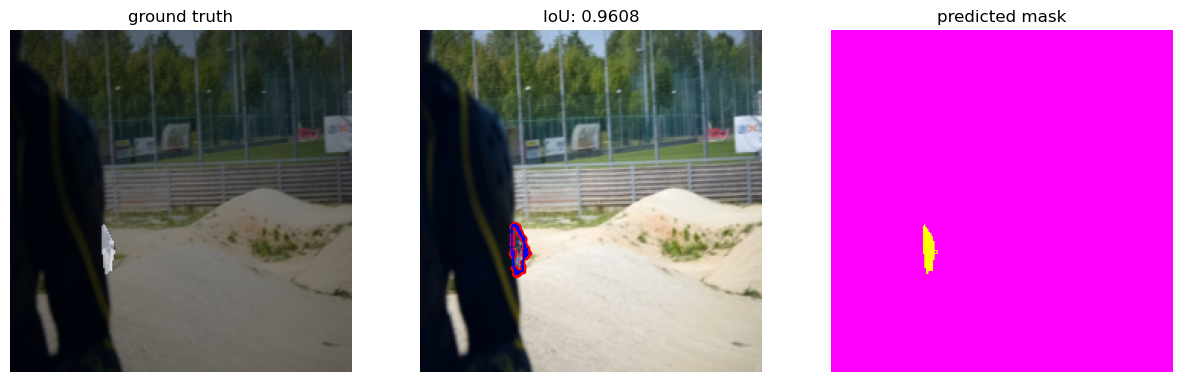

In [176]:
video_idx = 1
frame_idx = 59
point_num = 256
show_result(
    train_rawset.data_set[video_idx][frame_idx][0],
    train_rawset.data_set[video_idx][frame_idx][1],
    new_train_sample_set[video_idx][frame_idx][point_num],
)

In [150]:
def get_average_iou(sample_set: list, point_num: int) -> float:
    iou_list = []
    for video_result in sample_set:
        for frame_result in video_result:
            iou_list.append(frame_result[point_num]["iou"])
    return np.mean(iou_list)
get_average_iou(val_sample_set, 256)

0.9191041864422216

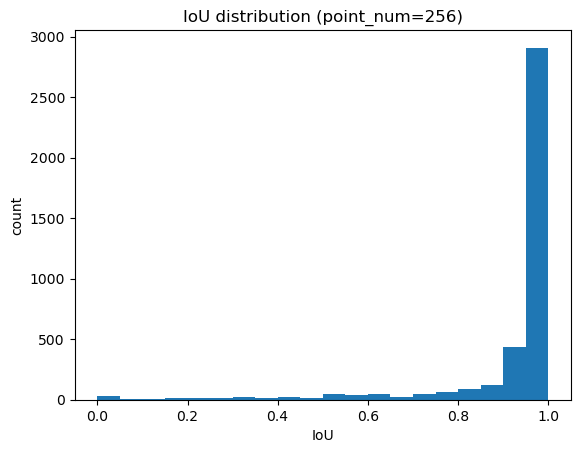

In [145]:
def show_iou_distribution(sample_set: list, point_num: int):
    iou_list = []
    for video_result in sample_set:
        for frame_result in video_result:
            iou_list.append(frame_result[point_num]["iou"])
    plt.hist(iou_list, bins=20)
    plt.title("IoU distribution (point_num=256)")
    plt.xlabel("IoU")
    plt.ylabel("count")
    plt.show()
show_iou_distribution(val_sample_set, 256)

In [265]:
def find_range_iou_frame(sample_set: list, point_num: int, low_threshold: float, high_threshold: float):
    range_iou_frames = []
    for video_idx, video_result in enumerate(sample_set):
        for frame_idx, frame_result in enumerate(video_result):
            iou = frame_result[point_num]["iou"]
            if iou < high_threshold and iou > low_threshold:
                range_iou_frames.append((video_idx, frame_idx))
                # print(f"video_idx: {video_idx}, frame_idx: {frame_idx}, iou: {iou:.4f}")
    return range_iou_frames
find_range_iou_frame(new_train_sample_set, 256, 0.2, 0.3)

[(1, 76),
 (27, 29),
 (29, 78),
 (49, 3),
 (49, 7),
 (49, 8),
 (49, 9),
 (49, 23),
 (49, 27),
 (49, 30),
 (49, 32),
 (49, 34),
 (49, 43),
 (49, 44),
 (49, 47),
 (49, 58),
 (49, 59),
 (58, 18),
 (58, 29),
 (60, 64),
 (60, 71),
 (66, 55),
 (77, 5),
 (104, 46),
 (107, 57),
 (107, 60),
 (107, 62),
 (107, 63),
 (112, 30),
 (112, 32),
 (112, 34),
 (112, 52),
 (112, 76),
 (112, 77),
 (127, 10),
 (127, 27)]

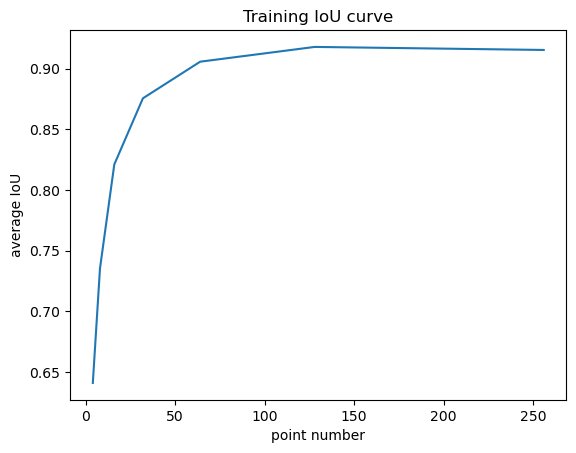

In [156]:
def plot_iou_curve(sample_set: list, title: str):
    point_num_list = [4, 8, 16, 32, 64, 128, 256]
    iou_list = [get_average_iou(sample_set, point_num) for point_num in point_num_list]
    plt.plot(point_num_list, iou_list)
    plt.title(f"{title} IoU curve")
    plt.xlabel("point number")
    plt.ylabel("average IoU")

plot_iou_curve(train_sample_set, "Training")

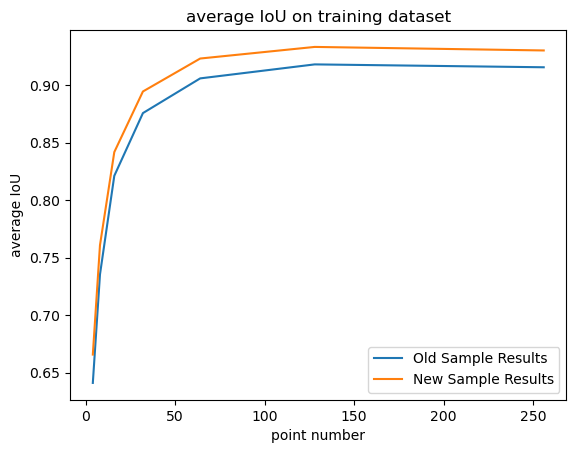

In [159]:
def compare_two_iou_curve(
    sample_set1: list,
    sample_set2: list,
    point_num: int,
    title: str,
):
    point_num_list = list(sample_set1[0][0].keys())
    iou_list1 = [get_average_iou(sample_set1, point_num) for point_num in point_num_list]
    iou_list2 = [get_average_iou(sample_set2, point_num) for point_num in point_num_list]
    plt.plot(point_num_list, iou_list1, label=f"Old Sample Results")
    plt.plot(point_num_list, iou_list2, label=f"New Sample Results")
    plt.xlabel("point number")
    plt.ylabel("average IoU")
    plt.legend()
    plt.title(f"average IoU on {title}")
    plt.show()
compare_two_iou_curve(train_sample_set, new_train_sample_set, 256, "training dataset")

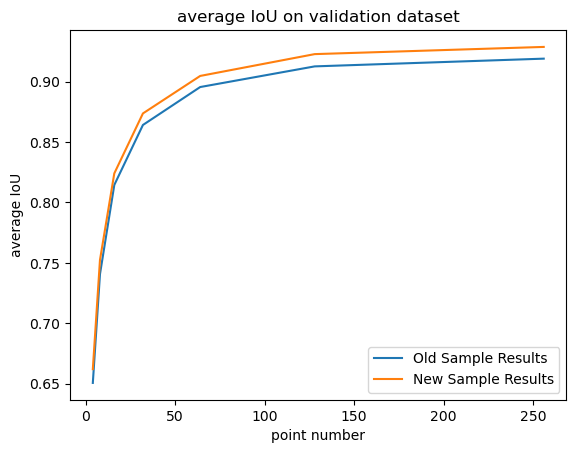

In [160]:
compare_two_iou_curve(val_sample_set, new_val_sample_set, 256, "validation dataset")

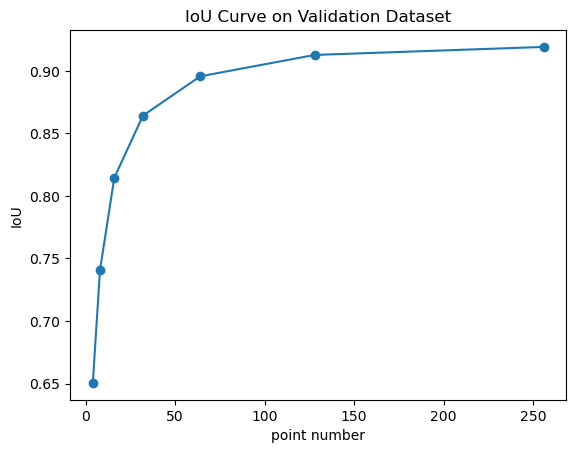

In [91]:
def plot_iou_curve(sample_set: list, title: str):
    point_num_list = [4, 8, 16, 32, 64, 128, 256]
    iou_list = [get_average_iou(sample_set, point_num) for point_num in point_num_list]
    plt.plot(point_num_list, iou_list, marker="o")
    plt.xlabel("point number")
    plt.ylabel("IoU")
    plt.title(title)
    plt.show()
plot_iou_curve(val_sample_set, "IoU Curve on Validation Dataset")

In [161]:
%load_ext autoreload
%autoreload 2

In [8]:
from preprocess_utensils import get_boundary_points, uniform_sample_points
import cv2 as cv

In [226]:
video_idx = 49
frame_idx = 3
img, mask = train_rawset.data_set[video_idx][frame_idx]
mask_np = mask.int().cpu().numpy().astype(np.uint8)
mask_np.sum()

8

In [213]:
def get_boundary_points(image: np.array) -> np.ndarray:
    """
    Get the boundary points of the largest component in the image.
    """

    # get the boundaries
    boundaries, contours = cv.findContours(
        image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE
    )
    boundaries = [np.squeeze(boundary) for boundary in boundaries]
    # print(boundaries)
    # get max-area boundary
    max_area = 0
    max_area_boundary = boundaries[0]
    for boundary in boundaries:
        if len(boundary) < 3:
            continue
        area = cv.contourArea(boundary)
        if area > max_area:
            max_area = area
            max_area_boundary = boundary
    if max_area_boundary.shape == (2,):
        # get the four points around it
        up_point = max_area_boundary.copy()
        up_point[1] = up_point[1] - 1
        down_point = max_area_boundary.copy()
        down_point[1] = down_point[1] + 1
        left_point = max_area_boundary.copy()
        left_point[0] = left_point[0] - 1
        right_point = max_area_boundary.copy()
        right_point[0] = right_point[0] + 1
        max_area_boundary = np.array([up_point, left_point, down_point, right_point])
    
    max_area_boundary = np.clip(max_area_boundary, 0, 224)

    return max_area_boundary

In [227]:
boundary = get_boundary_points(mask_np)
boundary

array([[ 54, 150],
       [ 54, 151],
       [ 54, 152],
       [ 54, 153],
       [ 55, 154],
       [ 55, 155],
       [ 55, 154],
       [ 55, 153],
       [ 55, 152],
       [ 54, 151]], dtype=int32)

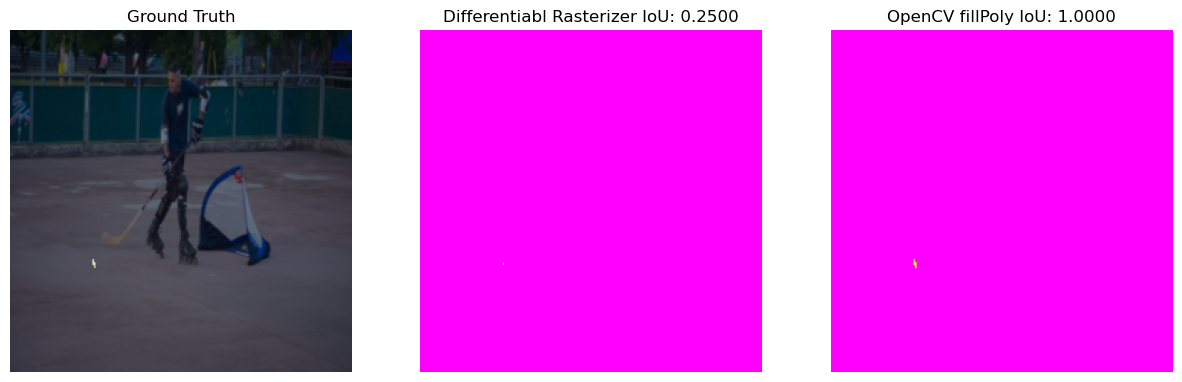

In [228]:
boundary_tensor = torch.tensor(boundary, dtype=torch.float32).cuda()
diff_iou = get_polygon_iou(boundary_tensor, mask.cuda(), hard_polygon)
pred_mask = hard_polygon(boundary_tensor.unsqueeze(0), 224, 224).squeeze(0).cpu().detach().numpy()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
# plt.plot(
#     boundary[:, 0],
#     boundary[:, 1],
#     "b-",
#     # lw=5,
# )
# plt.scatter(
#     boundary[:, 0],
#     boundary[:, 1],
#     c="r",
#     s=20,
# )
plt.imshow(
    mask.cpu().numpy(),
    alpha=0.5,
    cmap="gray",
)
plt.title(f"Ground Truth")
plt.subplot(1, 3, 2)
plt.imshow(
    pred_mask,
    cmap="spring",
    vmin=0,
    vmax=1,
)
plt.axis("off")
plt.title(f"Differentiabl Rasterizer IoU: {diff_iou:.4f}")
plt.subplot(1, 3, 3)
# use the opencv to fill the boundary
mask_np = mask_np * 255
mask_np = mask_np.astype(np.uint8)
cv.fillPoly(mask_np, [boundary.astype(np.int32)], 1)
plt.imshow(mask_np, cmap="spring")
plt.axis("off")
fill_iou = get_boundary_iou(mask.numpy(), boundary)
plt.title(f"OpenCV fillPoly IoU: {fill_iou:.4f}")
plt.show()

In [323]:
get_boundary_iou(mask_np, boundary)

0.821917808219178

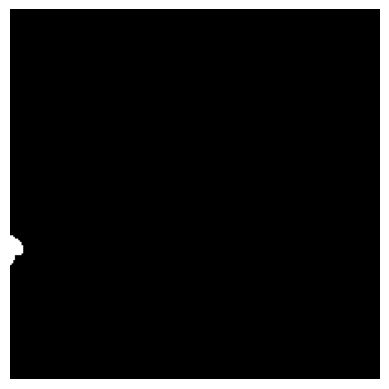

In [324]:
mask_cv = np.zeros(mask_np.shape[:2], dtype=np.uint8)
mask_cv = cv.fillPoly(mask_cv, [boundary.astype(np.int32)], 1)
mask_cv = cv.drawContours(
    mask_cv,
    [boundary.astype(np.int32)],
    -1,
    1,
    2,
)
plt.imshow(mask_cv, cmap="gray")
plt.axis("off")
plt.show()

In [325]:
boundary = get_boundary_points(mask_cv)

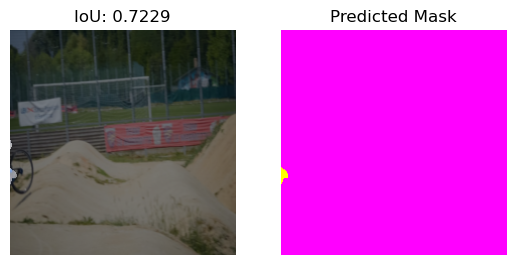

In [326]:
boundary_tensor = torch.tensor(boundary, dtype=torch.float32).cuda()
iou = get_polygon_iou(boundary_tensor, mask.cuda(), hard_polygon)
pred_mask = hard_polygon(boundary_tensor.unsqueeze(0), 224, 224).squeeze(0).cpu().detach().numpy()
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
# plt.plot(
#     boundary[:, 0],
#     boundary[:, 1],
#     "b-",
#     # lw=5,
# )
# plt.scatter(
#     boundary[:, 0],
#     boundary[:, 1],
#     c="r",
#     s=1,
# )
plt.imshow(
    mask.cpu().numpy(),
    alpha=0.5,
    cmap="gray",
)
plt.title(f"IoU: {iou:.4f}")
plt.subplot(1, 2, 2)
plt.imshow(
    pred_mask,
    cmap="spring",
    vmin=0,
    vmax=1,
)
plt.axis("off")
plt.title("Predicted Mask")
plt.show()

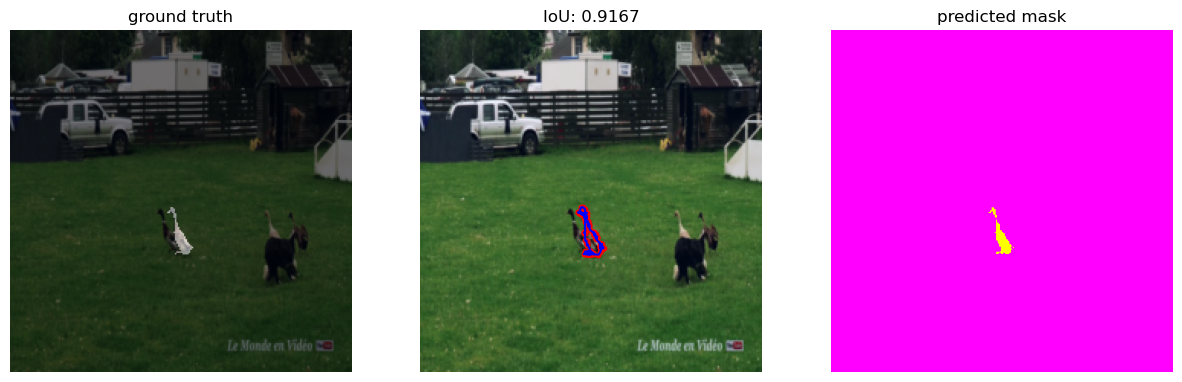

In [258]:
show_result(img, mask, new_train_sample_set[video_idx][frame_idx][256])

In [193]:
def get_uniformly_bounadry(mask: torch.Tensor, point_num: int) -> np.ndarray:
    mask_np = mask.cpu().numpy().astype(np.uint8)
    mask_cv = np.zeros(mask_np.shape[:2], dtype=np.uint8)
    boundary = get_boundary_points(mask_np)
    mask_cv = cv.fillPoly(mask_cv, [boundary.astype(np.int32)], 1)
    mask_cv = cv.drawContours(
        mask_cv,
        [boundary.astype(np.int32)],
        -1,
        1,
        2,
    )
    boundary = get_boundary_points(mask_cv)
    boundary = uniform_sample_points(boundary, point_num)
    return boundary

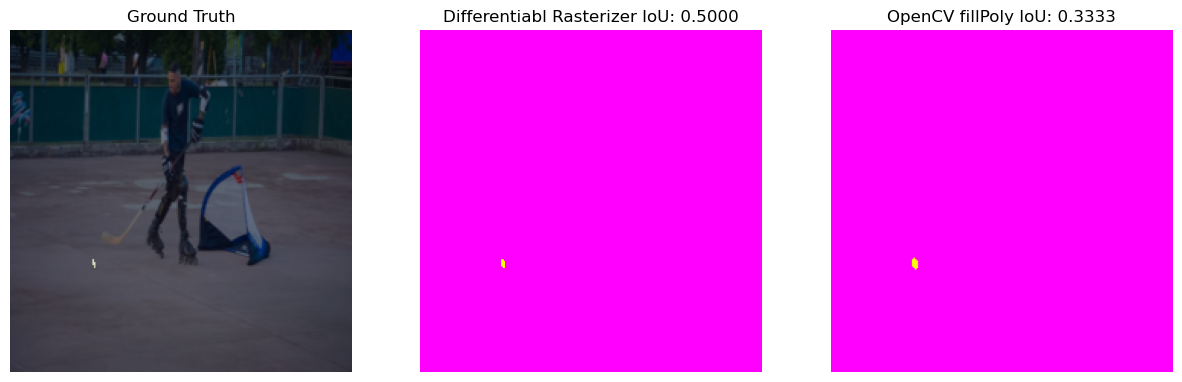

In [229]:
boundary = get_uniformly_bounadry(mask, 256)
boundary_tensor = torch.tensor(boundary, dtype=torch.float32).cuda()
diff_iou = get_polygon_iou(boundary_tensor, mask.cuda(), hard_polygon)
pred_mask = hard_polygon(boundary_tensor.unsqueeze(0), 224, 224).squeeze(0).cpu().detach().numpy()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
# plt.plot(
#     boundary[:, 0],
#     boundary[:, 1],
#     "b-",
#     # lw=5,
# )
# plt.scatter(
#     boundary[:, 0],
#     boundary[:, 1],
#     c="r",
#     s=20,
# )
plt.imshow(
    mask.cpu().numpy(),
    alpha=0.5,
    cmap="gray",
)
plt.title(f"Ground Truth")
plt.subplot(1, 3, 2)
plt.imshow(
    pred_mask,
    cmap="spring",
    vmin=0,
    vmax=1,
)
plt.axis("off")
plt.title(f"Differentiabl Rasterizer IoU: {diff_iou:.4f}")
plt.subplot(1, 3, 3)
# use the opencv to fill the boundary
mask_np = mask_np * 255
mask_np = mask_np.astype(np.uint8)
cv.fillPoly(mask_np, [boundary.astype(np.int32)], 1)
plt.imshow(mask_np, cmap="spring")
plt.axis("off")
fill_iou = get_boundary_iou(mask.numpy(), boundary)
plt.title(f"OpenCV fillPoly IoU: {fill_iou:.4f}")
plt.show()

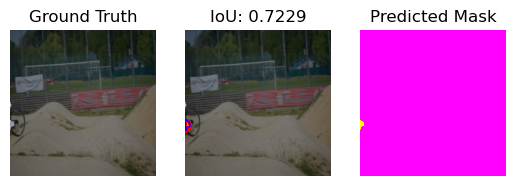

In [22]:
video_idx = 1
frame_idx = 44
img, mask = train_rawset.data_set[video_idx][frame_idx]
boundary = get_uniformly_bounadry(mask, 256)
def show_one_frame_np_result(
    img: torch.Tensor,
    mask: torch.Tensor,
    boundary: np.ndarray,
    hard_polygon: nn.Module,
):
    boundary_tensor = torch.tensor(boundary, dtype=torch.float32).cuda()
    iou = get_polygon_iou(boundary_tensor, mask.cuda(), hard_polygon)
    pred_mask = hard_polygon(boundary_tensor.unsqueeze(0), 224, 224).squeeze(0).cpu().detach().numpy()
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.imshow(mask.cpu().numpy(), alpha=0.5, cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.plot(
        boundary[:, 0],
        boundary[:, 1],
        "b-",
        lw=1,
    )
    plt.scatter(
        boundary[:, 0],
        boundary[:, 1],
        c="r",
        s=1,
    )
    plt.imshow(
        mask.cpu().numpy(),
        alpha=0.5,
        cmap="gray",
    )
    plt.title(f"IoU: {iou:.4f}")
    plt.subplot(1, 3, 3)
    plt.imshow(
        pred_mask,
        cmap="spring",
        vmin=0,
        vmax=1,
    )
    plt.axis("off")
    plt.title("Predicted Mask")
    plt.show()
show_one_frame_np_result(img, mask, boundary, hard_polygon)

In [36]:
train_low_iou_idx_list = find_range_iou_frame(new_train_sample_set, 256, 0.0, 0.8)
len(train_low_iou_idx_list)

857

In [57]:
def resample_boundaries(
    low_iou_idx_list: list,
    dataset: list,
    point_num: int,
    hard_polygon: nn.Module,
):
    results = []
    for video_idx, frame_idx in tqdm(low_iou_idx_list):
        img, mask = dataset[video_idx][frame_idx]
        boundary = get_uniformly_bounadry(mask, point_num)
        boundary_tensor = torch.tensor(boundary, dtype=torch.float32).cuda()
        iou = get_polygon_iou(boundary_tensor, mask.cuda(), hard_polygon)
        results.append(
            {
                "idx": (video_idx, frame_idx),
                "boundary": boundary.tolist(),
                "iou": iou,
            },
        )
    return results
new_low_iou_boundaries = resample_boundaries(train_low_iou_idx_list, train_rawset.data_set, 256, hard_polygon)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 857/857 [00:00<00:00, 991.86it/s]


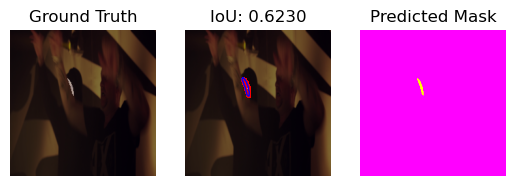

In [63]:
idx = 85
video_idx, frame_idx = new_low_iou_boundaries[idx]["idx"]
img, mask = train_rawset.data_set[video_idx][frame_idx]
boundary = np.array(new_low_iou_boundaries[idx]["boundary"])
show_one_frame_np_result(img, mask, boundary, hard_polygon)

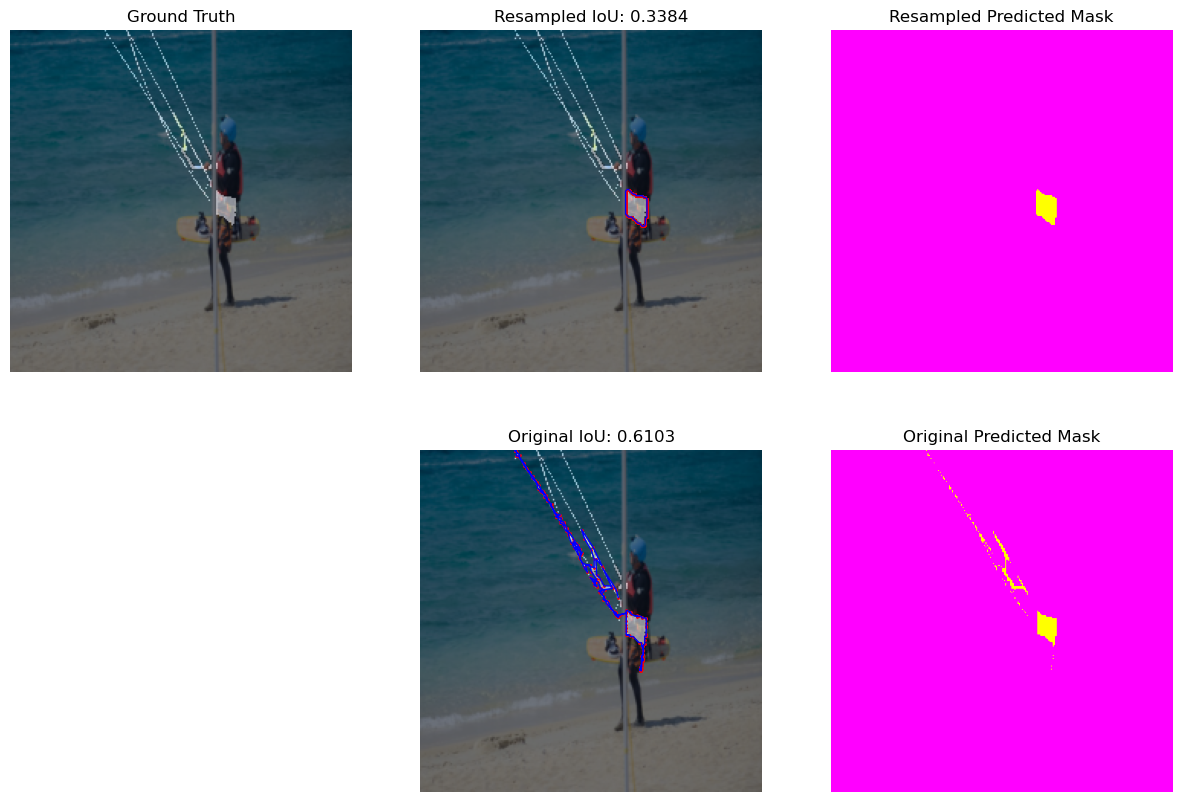

In [81]:
def compare_one_frame_results(
    img: torch.Tensor,
    mask: torch.Tensor,
    boundary1: np.ndarray,
    title1: str,
    boundary2: np.ndarray,
    title2: str,
    hard_polygon: nn.Module,
):
    boundary_tensor1 = torch.tensor(boundary1, dtype=torch.float32).cuda()
    iou1 = get_polygon_iou(boundary_tensor1, mask.cuda(), hard_polygon)
    pred_mask1 = hard_polygon(boundary_tensor1.unsqueeze(0), 224, 224).squeeze(0).cpu().detach().numpy()
    boundary_tensor2 = torch.tensor(boundary2, dtype=torch.float32).cuda()
    iou2 = get_polygon_iou(boundary_tensor2, mask.cuda(), hard_polygon)
    pred_mask2 = hard_polygon(boundary_tensor2.unsqueeze(0), 224, 224).squeeze(0).cpu().detach().numpy()
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.imshow(mask.cpu().numpy(), alpha=0.5, cmap="gray")
    plt.subplot(2, 3, 2)
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.plot(
        boundary1[:, 0],
        boundary1[:, 1],
        "b-",
        lw=1,
    )
    plt.scatter(
        boundary1[:, 0],
        boundary1[:, 1],
        c="r",
        s=1,
    )
    plt.imshow(
        mask.cpu().numpy(),
        alpha=0.5,
        cmap="gray",
    )
    plt.title(f"{title1} IoU: {iou1:.4f}")
    plt.subplot(2, 3, 3)
    plt.imshow(
        pred_mask1,
        cmap="spring",
        vmin=0,
        vmax=1,
    )
    plt.axis("off")
    plt.title(f"{title1} Predicted Mask")
    plt.subplot(2, 3, 5)
    plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.plot(
        boundary2[:, 0],
        boundary2[:, 1],
        "b-",
        lw=1,
    )
    plt.scatter(
        boundary2[:, 0],
        boundary2[:, 1],
        c="r",
        s=1,
    )
    plt.imshow(
        mask.cpu().numpy(),
        alpha=0.5,
        cmap="gray",
    )
    plt.title(f"{title2} IoU: {iou2:.4f}")
    plt.subplot(2, 3, 6)
    plt.imshow(
        pred_mask2,
        cmap="spring",
        vmin=0,
        vmax=1,
    )
    plt.axis("off")
    plt.title(f"{title2} Predicted Mask")
    plt.show()
idx = 256
video_idx, frame_idx = new_low_iou_boundaries[idx]["idx"]
img, mask = train_rawset.data_set[video_idx][frame_idx]
boundary_1 = np.array(new_low_iou_boundaries[idx]["boundary"])
boundary_2 = new_train_sample_set[video_idx][frame_idx][256]["boundary"]
boundary_2 = np.array(boundary_2)
compare_one_frame_results(img, mask, boundary_1, "Resampled", boundary_2, "Original", hard_polygon)


In [85]:
new_new_train_sample_set = deepcopy(new_train_sample_set)

In [86]:
def resample_low_iou_results(
    sample_set: list,
    iou_threshold: float,
    dataset: list,
    hard_polygon: nn.Module,
):
    for video_idx, video_result in enumerate(sample_set):
        for frame_idx, frame_result in enumerate(video_result):
            for point_num, result in frame_result.items():
                if result["iou"] < iou_threshold:
                    img, mask = dataset[video_idx][frame_idx]
                    boundary = get_uniformly_bounadry(mask, point_num)
                    boundary_tensor = torch.tensor(boundary, dtype=torch.float32).cuda()
                    iou = get_polygon_iou(boundary_tensor, mask.cuda(), hard_polygon)
                    if iou > result["iou"]:
                        new_result = {
                            "boundary": boundary.tolist(),
                            "iou": iou,
                        }
                        sample_set[video_idx][frame_idx][point_num] = new_result
resample_low_iou_results(new_new_train_sample_set, 0.8, train_rawset.data_set, hard_polygon)

In [90]:
get_average_iou(new_new_train_sample_set, 256), get_average_iou(new_train_sample_set, 256)

(0.9337849960326176, 0.93010638688533)

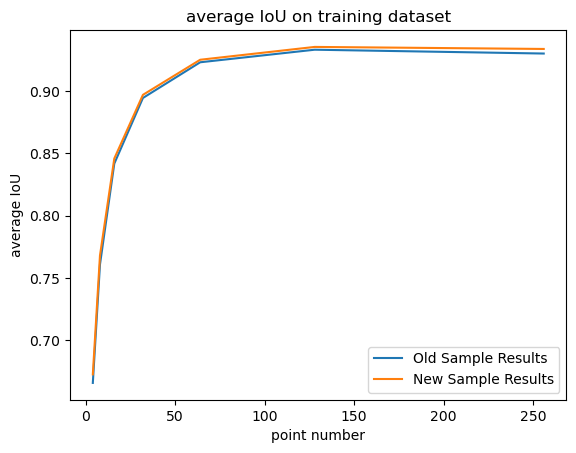

In [232]:
compare_two_iou_curve(new_train_sample_set, new_new_train_sample_set, 256, "training dataset")

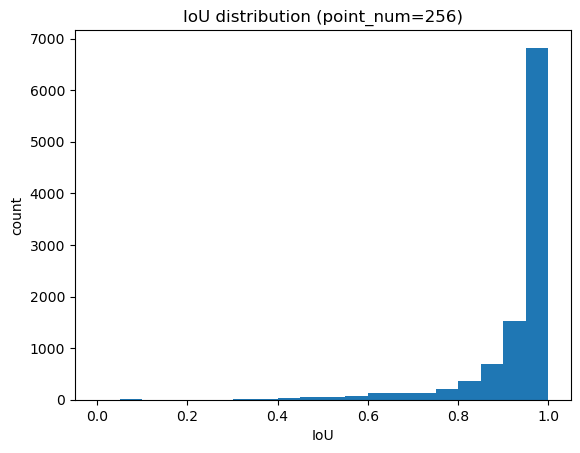

In [233]:
show_iou_distribution(new_new_train_sample_set, 256)

In [91]:
new_new_val_sample_set = deepcopy(new_val_sample_set)

In [92]:
resample_low_iou_results(new_new_val_sample_set, 0.8, val_rawset.data_set, hard_polygon)

In [94]:
get_average_iou(new_new_val_sample_set, 256), get_average_iou(new_val_sample_set, 256)

(0.9326906370795724, 0.9288170297547904)

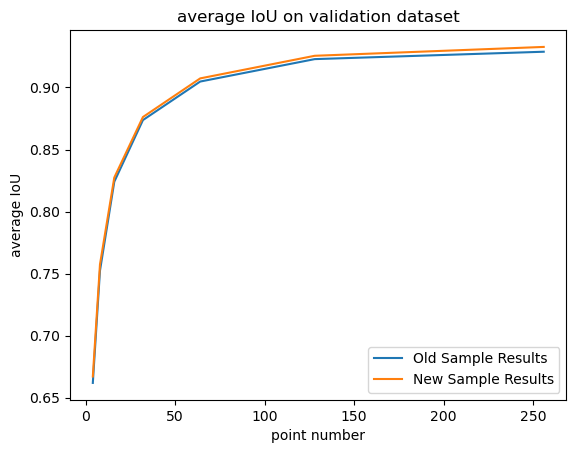

In [234]:
compare_two_iou_curve(new_val_sample_set, new_new_val_sample_set, 256, "validation dataset")

In [135]:
# save the new results
def save_results(results: list, save_title: str):
    save_path = f"./sample_results/{save_title}.json"
    with open(save_path, "w") as f:
        json.dump(results, f, )
save_results(new_new_val_sample_set, "val_256_uniform")

In [136]:
save_results(new_new_train_sample_set, "train_256_uniform")

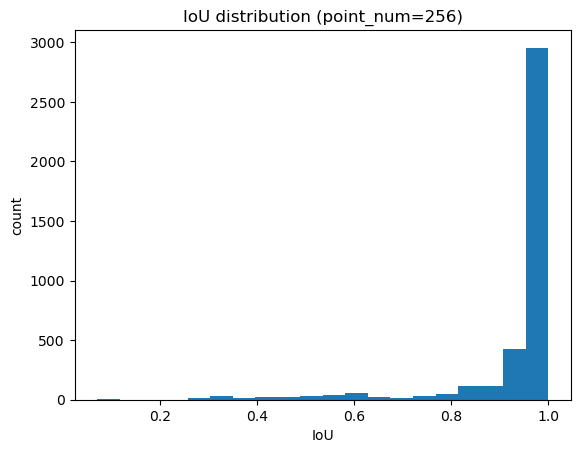

In [235]:
show_iou_distribution(new_new_val_sample_set, 256)

In [277]:
find_range_iou_frame(new_new_train_sample_set, 256, 0.8, 0.9)

[(2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 5),
 (2, 6),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (2, 27),
 (2, 28),
 (2, 29),
 (2, 30),
 (2, 36),
 (2, 38),
 (2, 39),
 (2, 41),
 (2, 42),
 (2, 43),
 (2, 44),
 (2, 45),
 (2, 46),
 (2, 48),
 (2, 76),
 (2, 77),
 (2, 78),
 (2, 79),
 (2, 80),
 (2, 81),
 (2, 82),
 (2, 84),
 (2, 85),
 (2, 86),
 (2, 87),
 (2, 88),
 (2, 89),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 5),
 (3, 6),
 (3, 8),
 (3, 13),
 (3, 24),
 (3, 27),
 (3, 28),
 (3, 31),
 (3, 33),
 (3, 34),
 (3, 36),
 (3, 38),
 (3, 39),
 (3, 41),
 (3, 42),
 (3, 52),
 (3, 53),
 (3, 54),
 (3, 68),
 (4, 83),
 (4, 84),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 19),
 (5, 24),
 (6, 25),
 (6, 27),
 (6, 46),
 (6, 53),
 (6, 66),
 (6, 67),
 (6, 68),
 (6, 69),
 (6, 80),
 (6, 81),
 (8, 47),
 (8, 48),
 (8, 49),
 (8, 50),
 (8, 53),
 (8, 54),
 (8, 55),
 (8, 56),
 (8, 57),
 (8, 58),
 (8, 59),
 (8, 60),
 (8, 61),
 (8, 62),
 (8, 63),
 (8, 64),
 (8

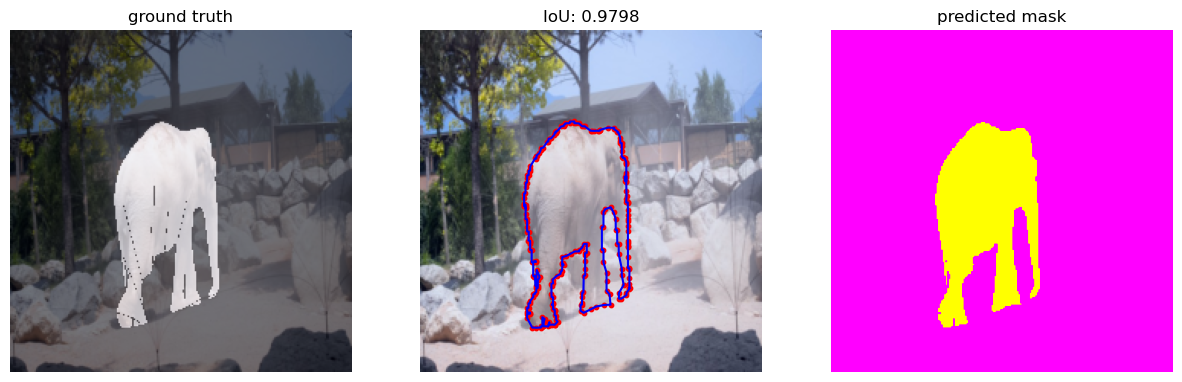

In [304]:
video_idx = 44
frame_idx = 62
point_num = 256
show_result(
    train_rawset.data_set[video_idx][frame_idx][0],
    train_rawset.data_set[video_idx][frame_idx][1],
    new_new_train_sample_set[video_idx][frame_idx][point_num],
)

In [4]:
class Sample_Rawset:
    def __init__(self, is_train: bool, output_size: tuple[int, int]) -> None:
        if is_train:
            data_type = "train"
        else:
            data_type = "val"
        data_path = f"./2017/{data_type}_video_datas.json"
        video_datas = json.load(open(data_path, "r"))
        self.data_set = []
        img_transforms = transforms.Compose(
            [
                transforms.Resize(output_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        anno_transform = transforms.Compose(
            [
                transforms.Resize(output_size),
                transforms.ToTensor(),
            ]
        )
        for video_name, video_data in video_datas.items():
            img_paths = video_data["img_paths"]
            anno_paths = video_data["anno_paths"]
            anno_colors = video_data["anno_colors"]
            for anno_color in anno_colors:
                self.data_set.append([])
                for img_path, anno_path in zip(img_paths, anno_paths):
                    img_tensor = img_transforms(Image.open(img_path))
                    anno_img = Image.open(anno_path).convert("RGB")
                    anno_array = np.array(anno_img)
                    anno_mask = reserve_color(anno_array, anno_color)
                    anno_tensor = anno_transform(Image.fromarray(anno_mask))
                    anno_tensor = anno_tensor.squeeze(0)
                    self.data_set[-1].append((img_tensor, anno_tensor))

In [5]:
train_sample_rawset = Sample_Rawset(is_train=True, output_size=(480, 854))

In [6]:
val_sample_rawset = Sample_Rawset(is_train=False, output_size=(480, 854))

In [37]:
class HighResoBouSampler(nn.Module):
    def __init__(
        self,
        img_size=(480, 854),
    ) -> None:
        super(HighResoBouSampler, self).__init__()
        self.img_size = img_size
        self.boundary_points = nn.Parameter(
            torch.tensor(
                [
                    [0, 0],
                    [0, img_size[0] - 1],
                    [img_size[1] - 1, img_size[0] - 1],
                    [img_size[1] - 1, 0],
                ],
                dtype=torch.float32,
            ),
        )
    
    def forward(self):
        boundary = self.boundary_points
        lower_bound = torch.tensor([0, 0], dtype=torch.float32).to(boundary.device)
        upper_bound = torch.tensor([self.img_size[1] - 1, self.img_size[0] - 1], dtype=torch.float32).to(boundary.device)
        boundary = torch.clamp(boundary, lower_bound, upper_bound)
        boundary = boundary.unsqueeze(0)
        return boundary
    
    def add_mid_points(self):
        # add mid points to the boundary
        boundary = self.boundary_points
        boundary_shift = torch.roll(boundary, 1, 0)
        # print(f"boundary: {boundary}")
        # print(f"boundary_shift: {boundary_shift}")
        mid_points = (boundary + boundary_shift) / 2
        # print(f"mid_points: {mid_points}")
        boundary_num = boundary.shape[0]
        new_boundary = torch.zeros(boundary_num * 2, 2).to(boundary.device)
        new_boundary[::2] = mid_points
        new_boundary[1::2] = boundary
        self.boundary_points = nn.Parameter(new_boundary)

    def get_numpy(self) -> np.ndarray:
        boundary = self.forward().squeeze(0).cpu().detach().numpy()
        return boundary

    def get_extreme_4_points(self):
        boundary = self.forward().squeeze(0)
        x_min = torch.min(boundary[:, 0])
        x_max = torch.max(boundary[:, 0])
        y_min = torch.min(boundary[:, 1])
        y_max = torch.max(boundary[:, 1])
        return torch.Tensor(
            [
                [x_min, y_min],
                [x_min, y_max],
                [x_max, y_max],
                [x_max, y_min],
            ],
        ).to(boundary.device)

In [165]:
high_reso_bou_sampler = HighResoBouSampler().cuda()

In [115]:
high_reso_bou_sampler().squeeze(0)

tensor([[187.3035,   0.0000],
        [187.3033, 479.0000],
        [662.6962, 479.0000],
        [662.6962,   0.0000]], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [134]:
img, mask = train_sample_rawset.data_set[video_idx][frame_idx]
img.shape, mask.shape

(torch.Size([3, 480, 854]), torch.Size([480, 854]))

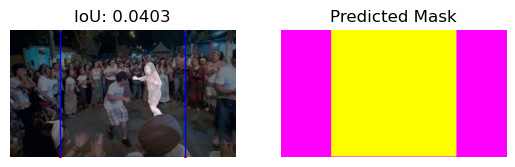

In [170]:
boundary = high_reso_bou_sampler().squeeze(0)
video_idx = 23
frame_idx = 15
img, mask = train_sample_rawset.data_set[video_idx][frame_idx]
iou = get_polygon_iou(boundary, mask.cuda(), hard_polygon)
boundary_np = boundary.cpu().detach().numpy()
plt.figure()
# plt.subplot(1, 3, 1)
# plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
# plt.axis("off")
# plt.imshow(mask.cpu().numpy(), alpha=0.5, cmap="gray")
# plt.title(f"Ground Truth")
# plt.subplot(1, 3, 2)
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.plot(
    boundary_np[:, 0],
    boundary_np[:, 1],
    "b-",
    lw=1,
)
plt.scatter(
    boundary_np[:, 0],
    boundary_np[:, 1],
    c="r",
    s=1,
)
plt.imshow(mask.cpu().numpy(), alpha=0.5, cmap="gray")
plt.title(f"IoU: {iou:.4f}")
# plt.subplot(1, 3, 3)
plt.subplot(1, 2, 2)
pred_mask = hard_polygon(boundary.unsqueeze(0), 854, 480).squeeze(0).cpu().detach().numpy()
plt.imshow(pred_mask, cmap="spring", vmin=0, vmax=1)
plt.axis("off")
plt.title("Predicted Mask")
plt.show()

In [87]:
MODE_MASK = "mask"
def dice_loss(
    input: torch.Tensor,
    target: torch.Tensor,
):
    smooth = 1.0

    iflat = input.reshape(-1)
    tflat = target.reshape(-1)
    intersection = (iflat * tflat).sum()

    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class RasLoss(nn.Module):
    def __init__(
        self,
        inv_smoothness=0.1,
        mode=MODE_MASK,
    ):
        super(RasLoss, self).__init__()

        self.inv_smoothness = inv_smoothness
        self.mode = mode
        self.soft_polygon = SoftPolygon(
            inv_smoothness=inv_smoothness,
            mode=mode,
        )
        self.loss_fn = dice_loss

    def forward(
        self,
        input: torch.Tensor,
        target: torch.Tensor,
    ):
        ras_ploygon = self.soft_polygon(
            input,
            target.shape[2],
            target.shape[1],
        )
        return self.loss_fn(ras_ploygon, target)

In [168]:
epoch_num = 1000
loss_dict = {}
loss_dict["dif_loss"] = []
loss_dict["cos_loss"] = []
loss_dict["std_loss"] = []
loss_dict["len_loss"] = []
loss_dict["total_loss"] = []
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(high_reso_bou_sampler.parameters(), lr=1)
dif_weight = 0.5
std_weight = 0.5
# len_weight = 0.1
mask_batch = mask.unsqueeze(0).cuda()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    boundary_points = high_reso_bou_sampler()
    dif_loss = ras_loss(boundary_points, mask_batch)
    std_loss = deviation_loss(boundary_points)
    len_loss = total_len_loss(boundary_points)
    if std_loss < 0.01:
        total_loss = dif_weight * dif_loss
    else:
        total_loss = dif_weight * dif_loss + std_weight * std_loss
    # if std_loss < 0.01:
    #     total_loss = dif_weight * dif_loss + len_weight * len_loss
    # else:
    #     total_loss = (
    #         dif_weight * dif_loss + std_weight * std_loss + len_weight * len_loss
    #     )
    loss_dict["dif_loss"].append(dif_loss.item())
    loss_dict["std_loss"].append(std_loss.item())
    loss_dict["len_loss"].append(len_loss.item())
    loss_dict["total_loss"].append(total_loss.item())
    # total_loss = boundary.mean()
    total_loss.backward()
    print(
        f"epoch: {epoch}, dif_loss: {dif_loss:.4f}, std_loss: {std_loss:.4f}, len_loss: {len_loss:.4f}, total_loss: {total_loss:.4f}",
    )
    optimizer.step()

epoch: 0, dif_loss: 0.9561, std_loss: 0.8348, len_loss: 2.9732, total_loss: 0.8955
epoch: 1, dif_loss: 0.9560, std_loss: 0.8304, len_loss: 2.9688, total_loss: 0.8932
epoch: 2, dif_loss: 0.9559, std_loss: 0.8259, len_loss: 2.9643, total_loss: 0.8909
epoch: 3, dif_loss: 0.9558, std_loss: 0.8214, len_loss: 2.9598, total_loss: 0.8886
epoch: 4, dif_loss: 0.9557, std_loss: 0.8170, len_loss: 2.9554, total_loss: 0.8863
epoch: 5, dif_loss: 0.9556, std_loss: 0.8125, len_loss: 2.9509, total_loss: 0.8841
epoch: 6, dif_loss: 0.9555, std_loss: 0.8080, len_loss: 2.9464, total_loss: 0.8818
epoch: 7, dif_loss: 0.9554, std_loss: 0.8036, len_loss: 2.9420, total_loss: 0.8795
epoch: 8, dif_loss: 0.9553, std_loss: 0.7991, len_loss: 2.9375, total_loss: 0.8772
epoch: 9, dif_loss: 0.9552, std_loss: 0.7946, len_loss: 2.9330, total_loss: 0.8749
epoch: 10, dif_loss: 0.9551, std_loss: 0.7902, len_loss: 2.9286, total_loss: 0.8726
epoch: 11, dif_loss: 0.9550, std_loss: 0.7857, len_loss: 2.9241, total_loss: 0.8703
ep

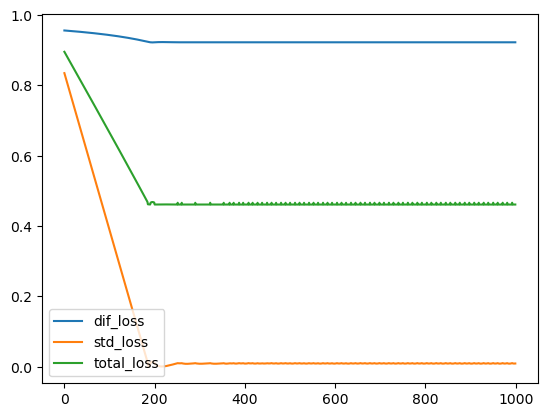

In [169]:
# plt the loss curve
plt.plot(loss_dict["dif_loss"], label="dif_loss")
# plt.plot(loss_dict["cos_loss"], label="cos_loss")
plt.plot(loss_dict["std_loss"], label="std_loss")
# plt.plot(loss_dict["len_loss"], label="len_loss")
plt.plot(loss_dict["total_loss"], label="total_loss")
plt.legend()

In [66]:
results = sample_one_frame(mask, 4, True, 10, hard_polygon, 100, ras_loss, high_reso_bou_sampler)

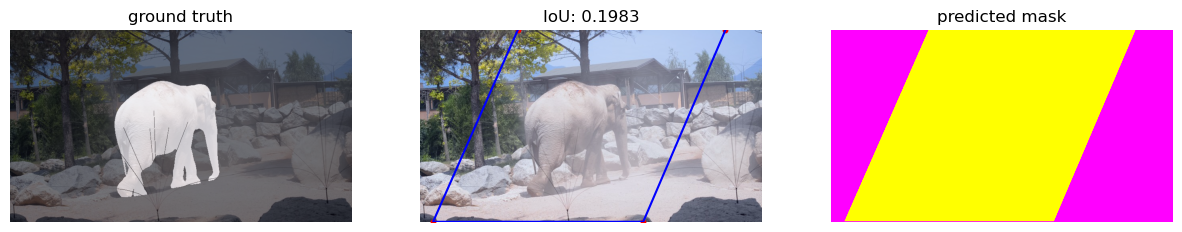

In [67]:
show_result(img, mask, results[4])